<a href="https://colab.research.google.com/github/Wanita-8943/run/blob/main/B3_G1_Train_2e-5_Freeze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#เรียกใช้ CSV

In [22]:
import pandas as pd
import shutil

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
df = pd.read_csv (r'/content/drive/MyDrive/cut_panoramic/Data/New_Data_Gender.csv')
df

,Fig_Age,Fig_Person_Sex,Age(year),Class,Class_Re,Filename,Path_filename,Sex,Floder
0,1,1,7,Y07F,0,V1.jpg,/content/drive/My Drive/TVT_Gender/train/Femal...,Female,Both
1,2,1,7,Y07F,0,Flip_V1.jpg,/content/drive/My Drive/TVT_Gender/train/Femal...,Female,Both
2,3,2,7,Y07F,0,V2.jpg,/content/drive/My Drive/TVT_Gender/train/Femal...,Female,Both
3,4,2,7,Y07F,0,Flip_V2.jpg,/content/drive/My Drive/TVT_Gender/train/Femal...,Female,Both
4,5,3,7,Y07F,0,V3.jpg,/content/drive/My Drive/TVT_Gender/train/Femal...,Female,Both
...,...,...,...,...,...,...,...,...,...
4745,121,77,25,Y25M,1,Flip_J463.jpg,/content/drive/My Drive/TVT_Gender/test/Male/F...,Male,Both
4746,122,78,25,Y25M,1,J464.jpg,/content/drive/My Drive/TVT_Gender/test/Male/J...,Male,Both
4747,123,78,25,Y25M,1,Flip_J464.jpg,/content/drive/My Drive/TVT_Gender/test/Male/F...,Male,Both
4748,124,79,25,Y25M,1,J465.jpg,/content/drive/My Drive/TVT_Gender/test/Male/J...,Male,Both


#Imports

In [25]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

#กำหนดค่าพารามิเตอร์


In [26]:
batch_size = 16
width = 150
height = 150
epochs = 250
NUM_TRAIN = 2850
NUM_TEST = 950
dropout_rate = 0.2
input_shape = (height, width, 3)

#Clone efficientnet repo


In [27]:
#ดึงข้อมูลใน Github มาใช้
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/


/content
/content/efficientnet_keras_transfer_learning


In [28]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB3 as Net
from efficientnet import center_crop_and_resize, preprocess_input

In [29]:
# loading pretrained conv base model
# โหลดโมเดล มาโดยตัด output ของโมเดลออก เเต่ยังใช้ input อันเดิม
# เเละโหลด weight ของโมเดล มาด้วยที่ชื่อว่า imagenet
conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)

In [30]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
# model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(2, activation='softmax', name="fc_out"))

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b3 (Functional  (None, 5, 5, 1536)       10783528  
 )                                                               
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1536)              0         
                                                                 
 dropout_out (Dropout)       (None, 1536)              0         
                                                                 
 fc_out (Dense)              (None, 2)                 3074      
                                                                 
Total params: 10,786,602
Trainable params: 10,699,306
Non-trainable params: 87,296
_________________________________________________________________


In [32]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers before freezing the conv base: 340
This is the number of trainable layers after freezing the conv base: 2


In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b3 (Functional  (None, 5, 5, 1536)       10783528  
 )                                                               
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1536)              0         
                                                                 
 dropout_out (Dropout)       (None, 1536)              0         
                                                                 
 fc_out (Dense)              (None, 2)                 3074      
                                                                 
Total params: 10,786,602
Trainable params: 3,074
Non-trainable params: 10,783,528
_________________________________________________________________


In [34]:
conv_base.summary() #ดู Summary

Model: "efficientnet-b3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_104 (Conv2D)            (None, 75, 75, 40)   1080        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_78 (BatchN  (None, 75, 75, 40)  160         ['conv2d_104[0][0]']             
 ormalization)                                                                                    
                                                                                    

#สร้างโฟลเดอร์ Train Valodation และ Test

In [35]:
base_dir = '/content/drive/MyDrive/TVT_Gender'
os.makedirs(base_dir, exist_ok=True)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)


#Train

In [36]:
# Train ด้วย ImageDataGenerator ของ Keras ซึ่งจะเพิ่มข้อมูลเสริมระหว่างการฝึกเพื่อลดโอกาสเกิด overfitting
#overfitting เกิดจากข้อมูลที่ซับซ้อนกันเกินไป
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, #โมเดลส่วนใหญ่ต้องใช้ RGB ในช่วง 0–1
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory #ไดเรกเป้าหมาย
        train_dir,
        # รูปภาพทั้งหมดจะถูกปรับขนาดตามความสูงและความกว้างของเป้าหมาย
        target_size=(height, width),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need categorical labels
        #เนื่องจากเราใช้ categorical_crossentropy loss เราจึงต้องมีป้ายกำกับตามหมวดหมู่
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory( #การดึงภาพจาก Directory มาเข้าโมเดล 
        validation_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')

Found 2850 images belonging to 2 classes.
Found 950 images belonging to 2 classes.


In [37]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])
history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

<ipython-input-37-95ae5648fc7b>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/250
178/178 [==============================] - 40s 166ms/step - loss: 1.3574 - acc: 0.5191 - val_loss: 1.1442 - val_acc: 0.4852
Epoch 2/250
178/178 [==============================] - 27s 150ms/step - loss: 1.2801 - acc: 0.5176 - val_loss: 1.0328 - val_acc: 0.5042
Epoch 3/250
178/178 [==============================] - 22s 123ms/step - loss: 1.2899 - acc: 0.5187 - val_loss: 0.9547 - val_acc: 0.5127
Epoch 4/250
178/178 [==============================] - 28s 151ms/step - loss: 1.2346 - acc: 0.5145 - val_loss: 0.9476 - val_acc: 0.5191
Epoch 5/250
178/178 [==============================] - 23s 123ms/step - loss: 1.3027 - acc: 0.4887 - val_loss: 0.9067 - val_acc: 0.5169
Epoch 6/250
178/178 [==============================] - 29s 158ms/step - loss: 1.2529 - acc: 0.5099 - val_loss: 0.9222 - val_acc: 0.5212
Epoch 7/250
178/178 [==============================] - 28s 154ms/step - loss: 1.2326 - acc: 0.4979 - val_loss: 0.8778 - val_acc: 0.5244
Epoch 8/250
178/178 [===========================

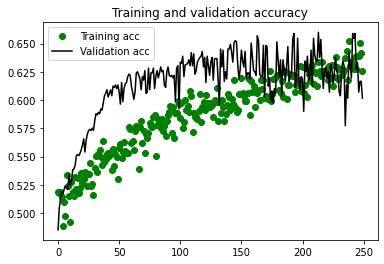

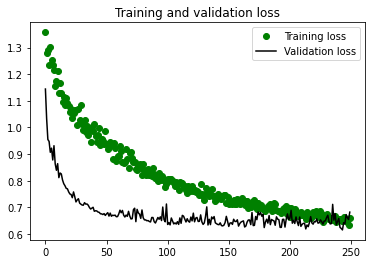

In [38]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'go', label='Training acc')
plt.plot(epochs_x, val_acc, 'k', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'go', label='Training loss')
plt.plot(epochs_x, val_loss, 'k', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#Download the model


In [39]:
# os.makedirs('/content/drive/My Drive/cut_panoramic/Model', exist_ok=True)
# model.save('/content/drive/My Drive/cut_panoramic/Model/B3_G1_2e-5_250.h5')

In [41]:
os.makedirs('/content/drive/My Drive/cut_panoramic/Model', exist_ok=True)
model.save('/content/drive/My Drive/cut_panoramic/Model/B3_G1_2e-5_250.h5')

In [40]:
# from google.colab import files
# files.download('/content/drive/My Drive/cut_panoramic/Model/1_รอบแรก_Gender_250.h5')